# CNN

Dans ce notebook nous allons implementer un CNN sur le dataset cats vs Dogs


In [1]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip



--2024-06-06 07:04:52--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.207, 173.194.203.207, 74.125.199.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   235MB/s    in 0.3s    

2024-06-06 07:04:52 (235 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
import zipfile

# Unzip the archive
local_zip = './cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()

zip_ref.close()

In [3]:
!ls -al

total 67020
drwxr-xr-x 1 root root     4096 Jun  6 07:04 .
drwxr-xr-x 1 root root     4096 Jun  6 06:42 ..
drwxr-xr-x 4 root root     4096 Jun  6 07:04 cats_and_dogs_filtered
-rw-r--r-- 1 root root 68606236 Mar 28  2018 cats_and_dogs_filtered.zip
drwxr-xr-x 4 root root     4096 Jun  4 13:31 .config
drwxr-xr-x 1 root root     4096 Jun  4 13:37 sample_data


In [4]:
!rm cats_and_dogs_filtered.zip

In [5]:
!ls -al ./cats_and_dogs_filtered/

total 20
drwxr-xr-x 4 root root 4096 Jun  6 07:04 .
drwxr-xr-x 1 root root 4096 Jun  6 07:04 ..
drwxr-xr-x 4 root root 4096 Jun  6 07:04 train
drwxr-xr-x 4 root root 4096 Jun  6 07:04 validation
-rw-r--r-- 1 root root  140 Jun  6 07:04 vectorize.py


In [6]:
!ls -al ./cats_and_dogs_filtered/train/cats | head


total 22684
drwxr-xr-x 2 root root 36864 Jun  6 07:04 .
drwxr-xr-x 4 root root  4096 Jun  6 07:04 ..
-rw-r--r-- 1 root root 12414 Jun  6 07:04 cat.0.jpg
-rw-r--r-- 1 root root 28377 Jun  6 07:04 cat.100.jpg
-rw-r--r-- 1 root root 11291 Jun  6 07:04 cat.101.jpg
-rw-r--r-- 1 root root 28635 Jun  6 07:04 cat.102.jpg
-rw-r--r-- 1 root root 24853 Jun  6 07:04 cat.103.jpg
-rw-r--r-- 1 root root 18941 Jun  6 07:04 cat.104.jpg
-rw-r--r-- 1 root root  6159 Jun  6 07:04 cat.105.jpg


## Explorer le dataset

In [7]:
import os
base_dir = "./cats_and_dogs_filtered/"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )


In [8]:
train_cat_fnames[:10]

['cat.779.jpg',
 'cat.589.jpg',
 'cat.506.jpg',
 'cat.942.jpg',
 'cat.44.jpg',
 'cat.584.jpg',
 'cat.75.jpg',
 'cat.276.jpg',
 'cat.158.jpg',
 'cat.724.jpg']

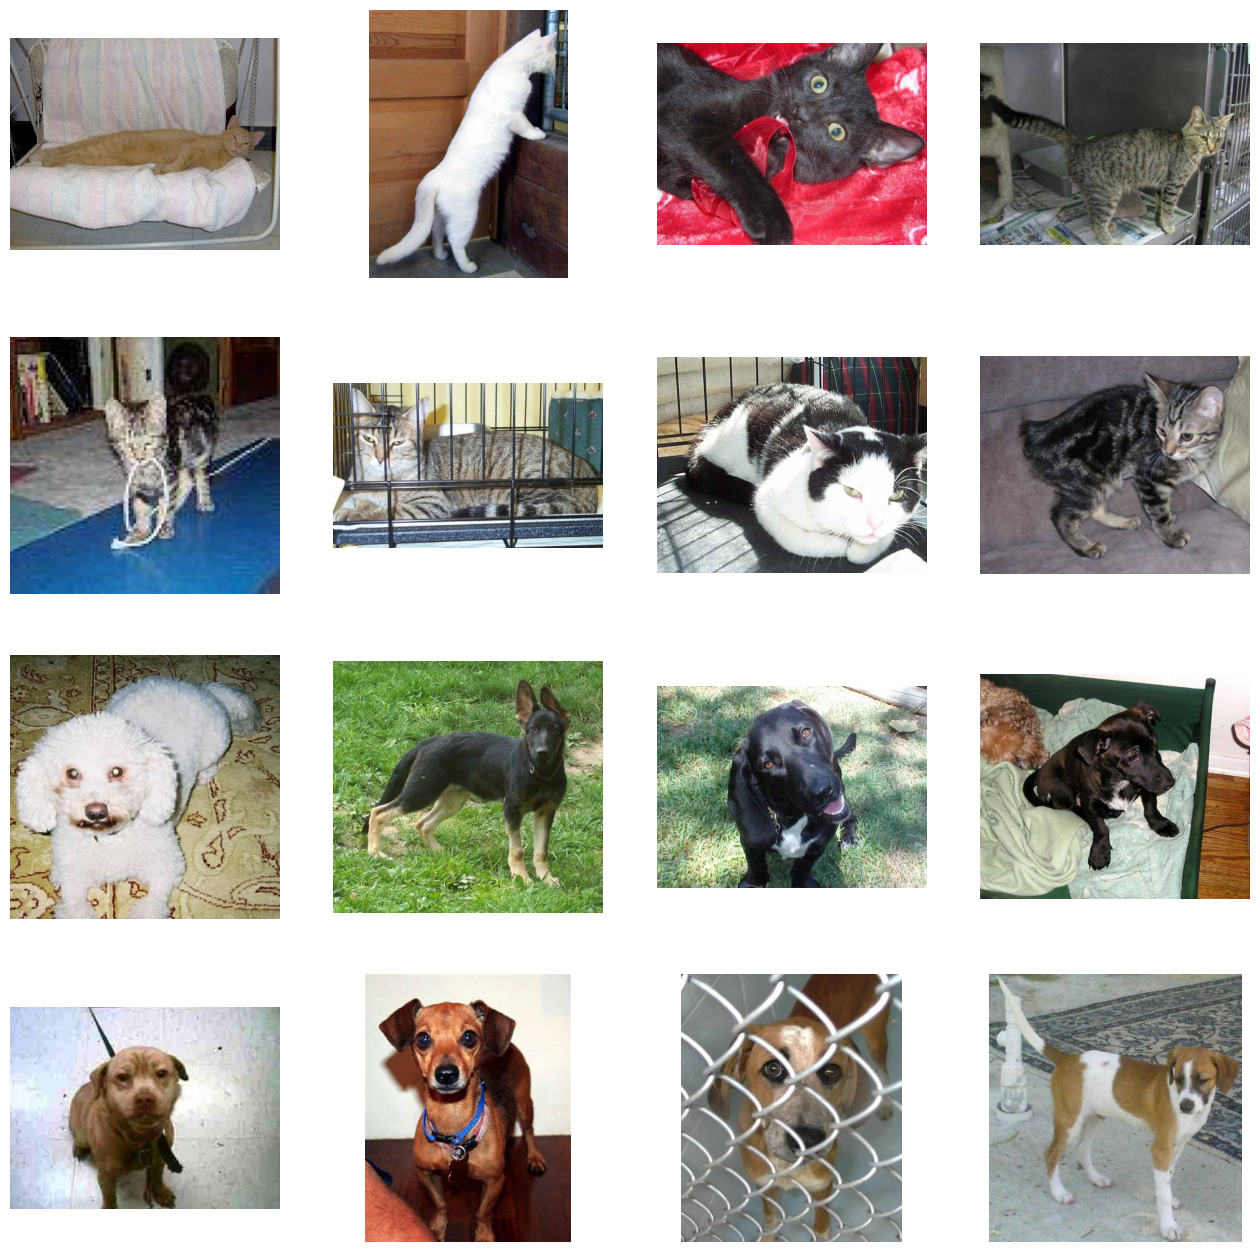

In [9]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in train_cat_fnames[ pic_index-8:pic_index]
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


# Simple CNN



In [10]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

In [12]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [14]:
history = model.fit(
            train_generator,
            epochs=15,
            validation_data=validation_generator,
            verbose=2
            )

Epoch 1/15
100/100 - 11s - loss: 0.7147 - accuracy: 0.5370 - val_loss: 0.6549 - val_accuracy: 0.6220 - 11s/epoch - 108ms/step
Epoch 2/15
100/100 - 5s - loss: 0.6470 - accuracy: 0.6120 - val_loss: 0.6568 - val_accuracy: 0.5610 - 5s/epoch - 51ms/step
Epoch 3/15
100/100 - 4s - loss: 0.5928 - accuracy: 0.6785 - val_loss: 0.5725 - val_accuracy: 0.6830 - 4s/epoch - 44ms/step
Epoch 4/15
100/100 - 5s - loss: 0.5342 - accuracy: 0.7255 - val_loss: 0.5569 - val_accuracy: 0.7210 - 5s/epoch - 54ms/step
Epoch 5/15
100/100 - 5s - loss: 0.4655 - accuracy: 0.7780 - val_loss: 0.8434 - val_accuracy: 0.6450 - 5s/epoch - 45ms/step
Epoch 6/15
100/100 - 6s - loss: 0.4197 - accuracy: 0.8065 - val_loss: 0.5383 - val_accuracy: 0.7310 - 6s/epoch - 55ms/step
Epoch 7/15
100/100 - 4s - loss: 0.3571 - accuracy: 0.8385 - val_loss: 0.5721 - val_accuracy: 0.7460 - 4s/epoch - 45ms/step
Epoch 8/15
100/100 - 4s - loss: 0.2673 - accuracy: 0.8875 - val_loss: 0.7462 - val_accuracy: 0.7130 - 4s/epoch - 44ms/step
Epoch 9/15
10